## Explains, visualizes, and analyses the ePodium dataset.

#### Import Packages

In [91]:
import mne
import numpy as np
import os

import PATH

from functions import dataset_loading
from functions import epodium

participant = "125b"

In [ ]:
# I would split off participant and make it a widget in a different cell maybe

#### Loading EEG-data and metadata

Make sure *PATH.ePod_dataset* contains the path to the __dataset__ and *PATH.ePod_metadata* contains the __metadata__ files

In [93]:
dataset_raw, dataset_filenames = dataset_loading.load_dataset(PATH.ePod_dataset, preload=False)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
epod_children, epod_cdi, epod_parents, epod_codes = \
    dataset_loading.load_metadata(PATH.ePod_metadata, epodium_metadata_filenames)

206 EEG files loaded


#### Load events

The ePodium experiment is an *auditory oddball experiment*. Children listen to a sequence that contains 80% standard and 20% deviant syllables in order to elicit the *mismatch response*. For measurement
34 electrodes are used, of which 32 channels and 2 mastoid references. The measure-
ment frequency is __2048.0 Hz__. Each test is around 30 minutes, containing four different
sequences of around 7.5 minutes

+ Sequence 1 __GiepMT__: standard "*giep*", deviant "*gip*": multiple pronounciations 
+ Sequence 2 __GiepST__: standard "*giep*", deviant "*gip*": single pronounciation 
+ Sequence 3 __GopMT__: standard "*gop*", deviant "*goep*": multiple pronounciations 
+ Sequence 4 __GopST__: standard "*gop*", deviant "*goep*": single pronounciation

The events are grouped into 12 event types, 3 for each sequence. Ideally, each sequence has 120 deviants __D__, 360 standards __S__, and 130 first standards __FS__. These first standards are there to make the child accustomed to the standard. First standards are discarded when calculating the mismatch response. 

Finally, your documentation is improving! Keep up the good markdown cells, I hope. 

In [94]:
# Save events (Set to true if PATH.ePod_events does not contain all events in .txt file)
# Events are stored external from raw file into .txt file for faster initialization
save_events_to_txt_file = False
if(save_events_to_txt_file):
    dataset_loading.save_events(PATH.ePod_events, dataset_raw, dataset_filenames)

events = dataset_loading.load_events(PATH.ePod_events, dataset_filenames)
# Set multiple pronounciations as same event id. This reduces the unique events from 78 to 12 distinct events.
events_12 = epodium.group_events_12(events)

206 Event Marker files loaded


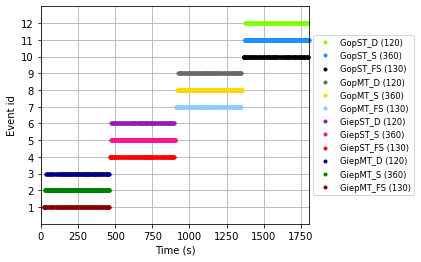

In [97]:
participant_events = events_12[dataset_filenames.index(participant)]
fig = mne.viz.plot_events(participant_events, event_id = epodium.event_dictionary, 
                          color = display_helper.color_dictionary, sfreq = 2048)

#### Show data fragment of ePOD dataset

Analysing file: 125b.bdf
Opening raw-browser...


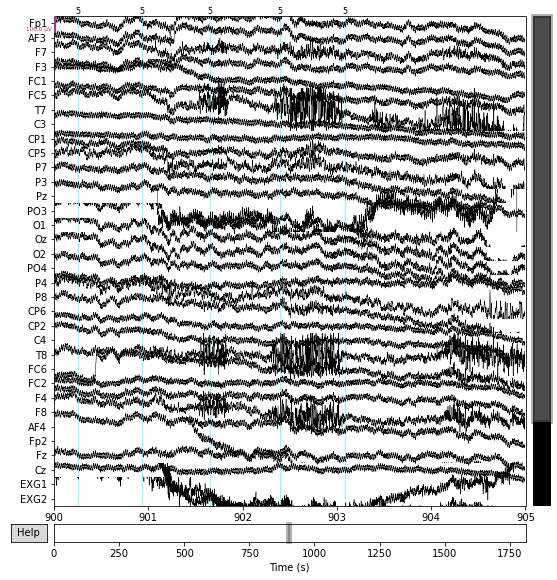

In [98]:
print(f"Analysing file: {participant}.bdf")
participant_raw = dataset_raw[dataset_filenames.index(participant)]
fig = mne.viz.plot_raw(participant_raw, participant_events, n_channels = 34, 
                       scalings = 50e-6, duration = 5, start = 900)

### Show ERPs of deviant, standard, and the MMN

Try to use the sciency approach to acronyms- first time you use them put the whole things and acronymn in parens e.g. mismatch negativity(MMN), then after that you can just say MMN

#### Load processed data

In [101]:
standard = "GiepMT_S" # GiepMT_S, GiepST_S, GopMT_S, GopST_S
deviant = "GiepMT_D" # GiepMT_D, 

path_processed_npy = os.path.join(PATH.processed, "ePod_autoreject", filename + ".npy")
path_processed_events = os.path.join(PATH.processed, "ePod_autoreject", "events", filename + ".txt")

npy = np.load(path_processed_npy)
info = mne.create_info(epodium.channel_names, 2048, ch_types='eeg')
events_12 = np.loadtxt(path_processed_events, dtype=int)

epochs = mne.EpochsArray(npy, info, events=events_12, tmin=-0.2, 
                         event_id=epodium.event_dictionary, verbose=False)
montage = mne.channels.make_standard_montage('standard_1020') 
epochs.info.set_montage(montage, on_missing = 'ignore')

print(npy.shape)

(1468, 32, 2049)


#### Deviant ERP

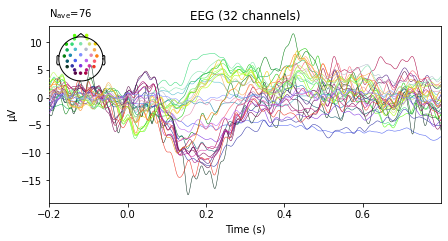

In [103]:
evoked_D = epochs['GiepST_D'].average()
fig = evoked_D.plot(spatial_colors = True)

#### Standard ERP

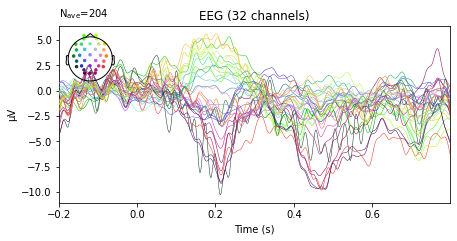

In [104]:
evoked_S = epochs['GiepST_S'].average()
fig = evoked_S.plot(spatial_colors = True)

#### MMN

Add a cell explaining what the MMN is!

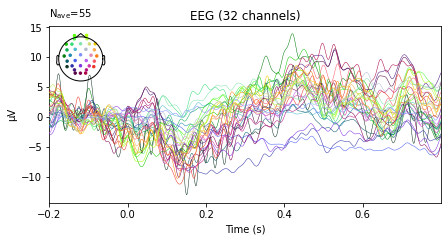

In [105]:
evoked_mmn = mne.combine_evoked([evoked_D, evoked_S], weights = [1, -1])
fig = evoked_mmn.plot(spatial_colors = True)